# Import 버전들 확인

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import sklearn
import sys
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate, RepeatedKFold
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm, randint, uniform, rv_continuous
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, Ridge
from xgboost import XGBRegressor
import xgboost
from pprint import pprint
from matplotlib import font_manager as fm

print('Numpy Version', np.__version__)
print('Pandas Version', pd.__version__)
print('Matplotlib Version', matplotlib.__version__)
print('Scikit-Learn Version', sklearn.__version__)
print('Tensorflow Version', tf.__version__)
print('Python Version', sys.version)

Numpy Version 1.23.5
Pandas Version 1.5.3
Matplotlib Version 3.7.1
Scikit-Learn Version 1.2.2
Tensorflow Version 2.12.0
Python Version 3.11.3 | packaged by Anaconda, Inc. | (main, Apr 19 2023, 23:46:34) [MSC v.1916 64 bit (AMD64)]


In [2]:
%matplotlib inline

In [3]:
#폰트 크기 조절

font_path = './segoeui.ttf'
font_prop = fm.FontProperties(fname=font_path)
matplotlib.rcParams['font.family'] = font_prop.get_name()
# matplotlib.rcParams['font.family'] = 'Comic Sans MS' 이걸 켜보면 모든 폰트가 다 바뀌는 것을 확인 가능
fs = 20 # 타이틀 크기
fss = 15 # xlabel 크기

DATA 읽어오기

In [4]:
raw_data = pd.read_excel('data_new/CERML_origin.xlsx')
print(raw_data)
feature_names = np.array(['Nnum', 'ed', 'Qe', 'Ecohe', 'EN', 'EA', 'I', 'rcov', 'rZ', 'Ne', 'N', 'dMN'])

     M      G_Cl  Nnum    ed    Qe  Ecohe    EN    EA     I  rcov    rZ  Ne  \
0   Mn  0.795966     4 -0.83  1.24  -0.36  1.55 -0.50  7.43  1.39  0.23   5   
1   Fe  0.858026     4 -0.62  1.37  -3.15  1.83  0.15  7.90  1.32  0.22   6   
2   Co  1.150586     4 -1.01  0.91  -2.81  1.88  0.66  7.88  1.26  0.21   7   
3   Ni  1.829476     4 -1.17  0.77  -4.69  1.92  1.16  7.64  1.24  0.20   8   
4   Cu  1.902396     4 -1.50  0.71  -2.48  1.90  1.24  7.73  1.32  0.19  10   
..  ..       ...   ...   ...   ...    ...   ...   ...   ...   ...   ...  ..   
70   W -2.478654     0 -0.90  1.73  -4.03  2.36  0.82  7.98  1.62  0.59   4   
71  Os -1.067414     0 -1.17  1.14  -2.09  2.20  1.08  8.71  1.44  0.54   6   
72  Ir -0.004404     0 -0.94  0.60  -1.82  2.20  1.56  8.97  1.41  0.53   7   
73  Pt  1.471646     0 -1.52  0.50  -3.19  2.28  2.13  8.96  1.36  0.51   9   
74  Au  1.570000     0 -3.33  0.50  -1.24  2.54  2.31  9.23  1.36  0.49  10   

     N   dMN  
0   25  2.22  
1   26  2.32  
2   27

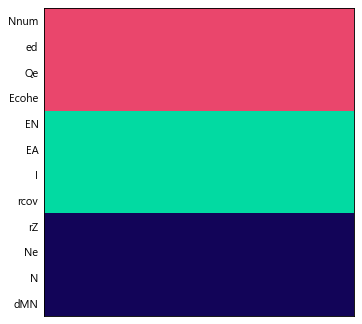

In [5]:
# Color 설정

color_a = '#EA466C'
color_b = '#02DAA2'
color_c = '#120458'

# Create the color list
colors = [color_a]*4 + [color_b]*4 + [color_c]*4 # 앞에서부터 원하는 범위까지 설정해주면 됨.

# 각 feature별로 칼라가 원하는대로 설정됐는지 확인

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=80)

for i, color in enumerate(colors):
    rect = mpatches.Rectangle((0, i), 1, 1, facecolor=color)
    ax.add_patch(rect)

ax.set_xlim(0, 1)
ax.set_ylim(0, len(colors))
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.tick_params(axis='x', which='both', bottom=False, top=False)

ax.set_yticks([i + 0.5 for i in range(len(colors))], minor=True)
ax.set_yticklabels(feature_names, minor=True)
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.tick_params(axis='y', which='both', left=False, right=False)
ax.invert_yaxis()

plt.show()

feature_colors = {name: color for name, color in zip(feature_names, colors)}

# Data preprocessing

In [6]:
print(raw_data)
data_cleaned = raw_data.iloc[:,2:] # input data들만 모은 array
print(data_cleaned)

     M      G_Cl  Nnum    ed    Qe  Ecohe    EN    EA     I  rcov    rZ  Ne  \
0   Mn  0.795966     4 -0.83  1.24  -0.36  1.55 -0.50  7.43  1.39  0.23   5   
1   Fe  0.858026     4 -0.62  1.37  -3.15  1.83  0.15  7.90  1.32  0.22   6   
2   Co  1.150586     4 -1.01  0.91  -2.81  1.88  0.66  7.88  1.26  0.21   7   
3   Ni  1.829476     4 -1.17  0.77  -4.69  1.92  1.16  7.64  1.24  0.20   8   
4   Cu  1.902396     4 -1.50  0.71  -2.48  1.90  1.24  7.73  1.32  0.19  10   
..  ..       ...   ...   ...   ...    ...   ...   ...   ...   ...   ...  ..   
70   W -2.478654     0 -0.90  1.73  -4.03  2.36  0.82  7.98  1.62  0.59   4   
71  Os -1.067414     0 -1.17  1.14  -2.09  2.20  1.08  8.71  1.44  0.54   6   
72  Ir -0.004404     0 -0.94  0.60  -1.82  2.20  1.56  8.97  1.41  0.53   7   
73  Pt  1.471646     0 -1.52  0.50  -3.19  2.28  2.13  8.96  1.36  0.51   9   
74  Au  1.570000     0 -3.33  0.50  -1.24  2.54  2.31  9.23  1.36  0.49  10   

     N   dMN  
0   25  2.22  
1   26  2.32  
2   27

여기서부터 Supervised Learning Part (SVM, Randomforest, NN)

Training set 나누기!

In [7]:
x = data_cleaned.astype(float)
y = raw_data.iloc[:,1].astype(float)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)  # 적당한 비율로 training과 test set을 나누는 부분

# Feature Importance Search

Data Scaling

In [8]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)
x_scaled = scaler.fit_transform(x)
x_train_scaled_df = pd.DataFrame(x_train_scaled, columns=x_train.columns)
x_test_scaled_df = pd.DataFrame(x_test_scaled, columns=x_test.columns)

Permutation functions 선언

In [9]:
def get_score_after_permutation(model, X, y, curr_feat):
    """ return the score of model when curr_feat is permuted """

    X_permuted = X.copy()
    col_idx = list(X.columns).index(curr_feat)
    # permute one column
    X_permuted.iloc[:, col_idx] = np.random.permutation(
        X_permuted[curr_feat].values)

    permuted_score = model.score(X_permuted, y)
    return permuted_score


def get_feature_importance(model, X, y, curr_feat):
    """ compare the score when curr_feat is permuted """

    baseline_score_train = model.score(X, y)
    permuted_score_train = get_score_after_permutation(model, X, y, curr_feat)

    # feature importance is the difference between the two scores
    feature_importance = baseline_score_train - permuted_score_train
    return feature_importance

def permutation_importance(model, X, y, n_repeats=10):
    """Calculate importance score for each feature."""

    importances = []
    for curr_feat in X.columns:
        list_feature_importance = []
        for n_round in range(n_repeats):
            list_feature_importance.append(
                get_feature_importance(model, X, y, curr_feat))

        importances.append(list_feature_importance)

    return {'importances_mean': np.mean(importances, axis=1),
            'importances_std': np.std(importances, axis=1),
            'importances': importances}

def plot_feature_importances(perm_importance_result, feat_name):
    """ bar plot the feature importance """

    fig, ax = plt.subplots()

    indices = perm_importance_result['importances_mean'].argsort()

    sorted_colors = [feature_colors[name] for name in feature_names[indices]]
    
    plt.barh(range(len(indices)),
             perm_importance_result['importances_mean'][indices],
             xerr=perm_importance_result['importances_std'][indices], color=sorted_colors)

    ax.set_yticks(range(len(indices)))
    _ = ax.set_yticklabels(feat_name[indices])

Data 분포 정의 for alpha values

In [10]:
class CustomExpNormal(rv_continuous):
    def __init__(self, mean, std):
        super().__init__()
        self.mean = mean
        self.std = std

    def _pdf(self, x):
        norm_factor = 1.0 / (self.std * np.sqrt(2 * np.pi))
        exponent = -0.5 * ((np.log(np.maximum(1e-10, x)) - self.mean) / self.std)**2

        valid_indices = x > 0
        pdf = np.zeros_like(x)
        pdf[valid_indices] = norm_factor * np.exp(exponent[valid_indices])

        return pdf

### 1. Ridge 기반 Feature importance

In [11]:
params_ridge = {'alpha': CustomExpNormal(0,3)}

In [12]:
ridge = Ridge()
ridge_random = RandomizedSearchCV(estimator = ridge, param_distributions=params_ridge, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1, scoring='neg_mean_squared_error')
ridge_random.fit(x_train_scaled_df, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=Ridge(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': <__main__.CustomExpNormal object at 0x000001F8857F4C90>},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [13]:
best_ridge = ridge_random.best_estimator_

print("Best Estimator:", ridge_random.best_params_)

print('Score on training set:', best_ridge.score(x_train_scaled_df, y_train))
print('Score on test set:', best_ridge.score(x_test_scaled_df, y_test))

Best Estimator: {'alpha': 2.0437883808141275}
Score on training set: 0.9219133807526501
Score on test set: 0.8299772761143321


In [14]:
predict_ridge_train = best_ridge.predict(x_train_scaled_df) # 최고의 개수로 학습한 거에 x_train을 넣은 결과
predict_ridge = best_ridge.predict(x_test_scaled_df) # 최고의 개수로 학습한 거에 x_test를 넣은 결과

mse_ridge_train = mean_squared_error(y_train, predict_ridge_train) # rdf에서 train set 에러
mse_ridge_test = mean_squared_error(y_test, predict_ridge) # rdf에서 test set 에러

print(mse_ridge_train)
print(mse_ridge_test)

0.1014006068659986
0.17578309496067313


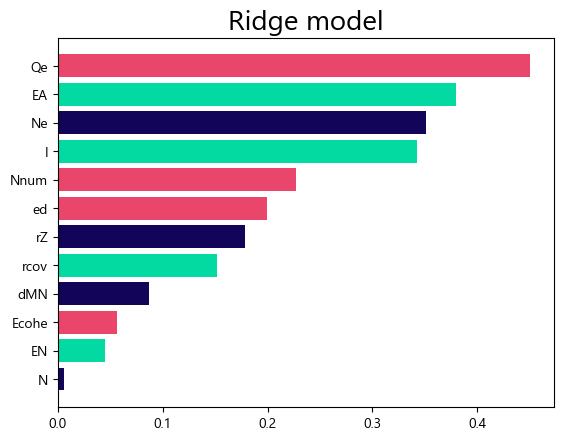

In [15]:
# Get the indices that would sort the feature importances
sort = np.abs(best_ridge.coef_).argsort()

sorted_colors = [feature_colors[name] for name in feature_names[sort]]

plt.barh(feature_names[sort], abs(best_ridge.coef_[sort]), color=sorted_colors)
plt.title('Ridge model', size=fs)
plt.savefig('Figs_original/Ridge.png')
plt.show()

#### Permutation도 보기

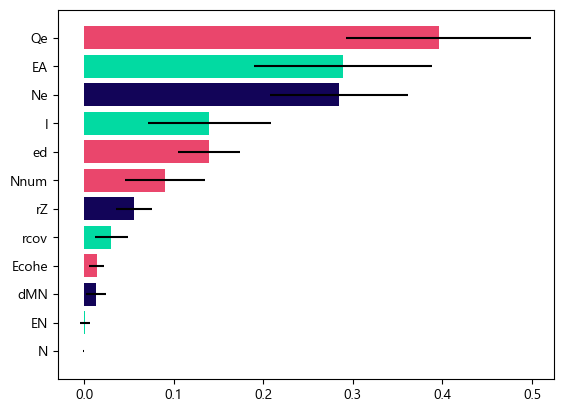

In [16]:
perm_importance_result_test = permutation_importance(best_ridge, x_test_scaled_df, y_test, n_repeats=10)
plot_feature_importances(perm_importance_result_test, x_test.columns)

### 2. Lasso 기반 Feautre importance

In [17]:
params_lasso = {'alpha': CustomExpNormal(0,3)}

In [18]:
lasso = Lasso()
lasso_random = RandomizedSearchCV(estimator = lasso, param_distributions=params_lasso, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1, scoring='neg_mean_squared_error')
lasso_random.fit(x_train_scaled_df, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=Lasso(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': <__main__.CustomExpNormal object at 0x000001F8859BDD90>},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [19]:
best_lasso = lasso_random.best_estimator_

print("Best Estimator:", lasso_random.best_params_)

print('Score on training set:', best_lasso.score(x_train_scaled_df, y_train))
print('Score on test set:', best_lasso.score(x_test_scaled_df, y_test))

Best Estimator: {'alpha': 0.08029389726155224}
Score on training set: 0.8590036676204755
Score on test set: 0.8128919683044883


In [20]:
predict_lasso_train = best_lasso.predict(x_train_scaled_df) # 최고의 개수로 학습한 거에 x_train을 넣은 결과
predict_lasso = best_lasso.predict(x_test_scaled_df) # 최고의 개수로 학습한 거에 x_test를 넣은 결과

mse_lasso_train = mean_squared_error(y_train, predict_lasso_train) # rdf에서 train set 에러
mse_lasso_test = mean_squared_error(y_test, predict_lasso) # rdf에서 test set 에러

print(mse_lasso_train)
print(mse_lasso_test)

0.18309300373058535
0.19344725311867142


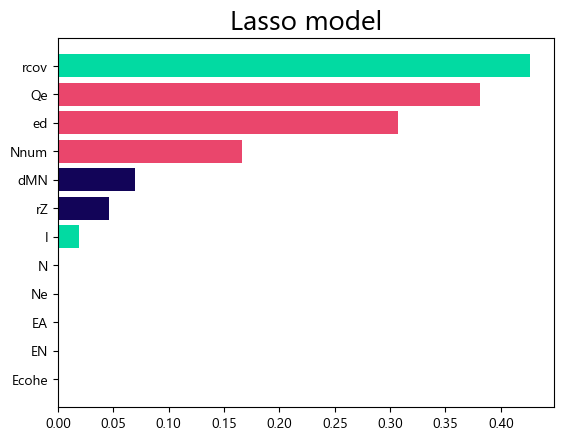

In [21]:
sort = np.abs(best_lasso.coef_).argsort()

sorted_colors = [feature_colors[name] for name in feature_names[sort]]

plt.barh(feature_names[sort], abs(best_lasso.coef_[sort]), color=sorted_colors)
plt.title('Lasso model', size=fs)
plt.savefig('Figs_original/Lasso.png')
plt.show()

#### Permutation도 보기

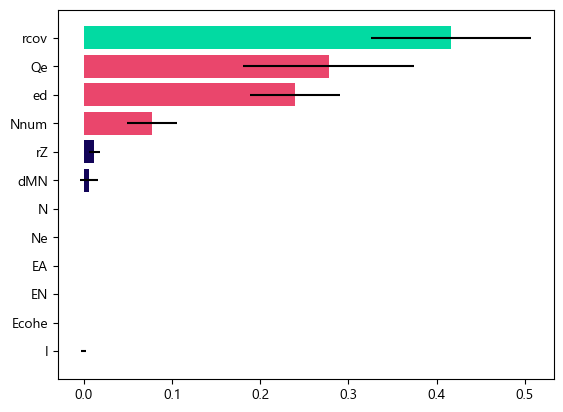

In [22]:
perm_importance_result_test = permutation_importance(best_lasso, x_test_scaled_df, y_test, n_repeats=10)
plot_feature_importances(perm_importance_result_test, x_test.columns)

### 3. RandomForest 기반 Feature importance

In [23]:
n_estimators = randint(100, 1000)

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

min_samples_split = [2, 5, 7, 10]

min_samples_leaf = [1, 2, 3, 4]

bootstrap = [True, False]

params_rf = {'n_estimators': n_estimators,
             'max_depth': max_depth,
             'min_samples_split': min_samples_split,
             'min_samples_leaf': min_samples_leaf,
             'bootstrap': bootstrap}
pprint(params_rf)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_leaf': [1, 2, 3, 4],
 'min_samples_split': [2, 5, 7, 10],
 'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F8834CBE90>}


In [24]:
rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = params_rf, n_iter = 250, cv = 5, verbose=2, random_state=42, n_jobs = -1, scoring='neg_mean_squared_error')

rf_random.fit(x_train, y_train)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=250,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 5, 7, 10],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F8834CBE90>},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [25]:
# 최적의 모델 및 파라미터 출력

best_rf = rf_random.best_estimator_

print("Best Estimator:", rf_random.best_params_)

print('Score on training set:', best_rf.score(x_train, y_train))
print('Score on test set:', best_rf.score(x_test, y_test))

Best Estimator: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 382}
Score on training set: 0.9933908846306304
Score on test set: 0.9270586463261372


In [26]:
predict_rf_train = best_rf.predict(x_train) # 최고의 개수로 학습한 거에 x_train을 넣은 결과
predict_rf = best_rf.predict(x_test) # 최고의 개수로 학습한 거에 x_test를 넣은 결과

mse_rf_train = mean_squared_error(y_train, predict_rf_train) # rdf에서 train set 에러
mse_rf_test = mean_squared_error(y_test, predict_rf) # rdf에서 test set 에러

print(mse_rf_train)
print(mse_rf_test)

0.008582370651476457
0.07541260724675096


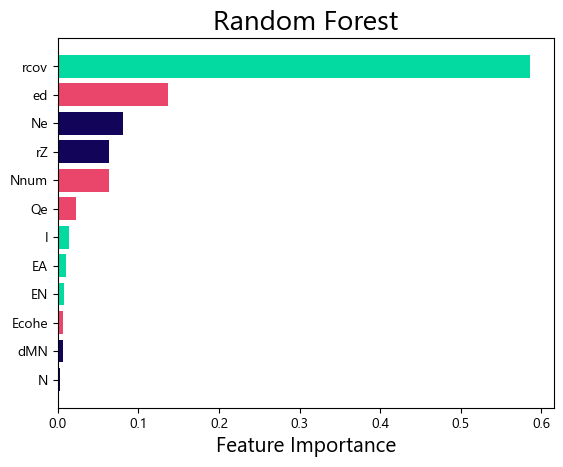

In [27]:
sort = best_rf.feature_importances_.argsort()
sorted_colors = [feature_colors[name] for name in feature_names[sort]]


plt.barh(feature_names[sort], best_rf.feature_importances_[sort], color = sorted_colors)

plt.title('Random Forest', fontsize=fs)
plt.xlabel("Feature Importance", fontsize=fss)
plt.savefig('Figs_original/RF.png')

#### Permutation도 보기

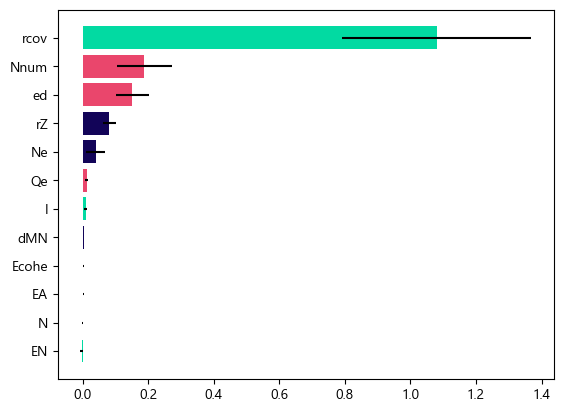

In [28]:
perm_importance_result_test = permutation_importance(best_rf, x_test, y_test, n_repeats=10)

plot_feature_importances(perm_importance_result_test, x_test.columns)

### 4. XGBoost 기반 Feature importance

In [29]:
params_xgb = {
    'n_estimators': randint(100, 1000),
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 2, 3, 4, 5],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1],
}

In [30]:
xgb = XGBRegressor()
xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = params_xgb, n_iter = 250, cv = 5, verbose=2, random_state=42, n_jobs = -1, scoring='neg_mean_squared_error')
xgb_random.fit(x_train, y_train)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.3],
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'min_child_weight': [1, 2, 3, 4, 5],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F886B9DD90>,
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [31]:
# 최적의 모델 및 파라미터 출력
print("Best Estimator:", xgb_random.best_params_)

print('Score on training set:', xgb_random.best_estimator_.score(x_train, y_train))
print('Score on test set:', xgb_random.best_estimator_.score(x_test, y_test))

best_xgb = xgb_random.best_estimator_

Best Estimator: {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 741, 'subsample': 0.9}
Score on training set: 0.9998935116900489
Score on test set: 0.9442087457770976


In [32]:
predict_xgb_train = best_xgb.predict(x_train) # 최고의 개수로 학습한 거에 x_train을 넣은 결과
predict_xgb = best_xgb.predict(x_test) # 최고의 개수로 학습한 거에 x_test를 넣은 결과

mse_xgb_train = mean_squared_error(y_train, predict_xgb_train) # rdf에서 train set 에러
mse_xgb_test = mean_squared_error(y_test, predict_xgb) # rdf에서 test set 에러

print(mse_xgb_train)
print(mse_xgb_test)

0.00013828206877512791
0.057681462306381784


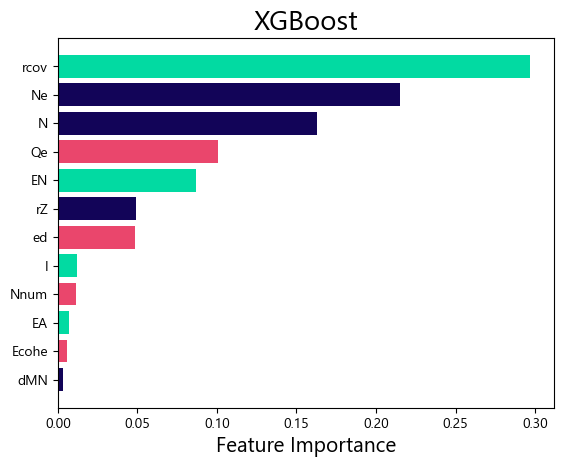

In [33]:
sort = best_xgb.feature_importances_.argsort()
sorted_colors = [feature_colors[name] for name in feature_names[sort]]

plt.barh(feature_names[sort], best_xgb.feature_importances_[sort], color=sorted_colors)
plt.title('XGBoost', fontsize=fs)
plt.xlabel("Feature Importance", fontsize=fss)
plt.savefig('Figs_original/XGBoost.png')

#### Permutation도 보기

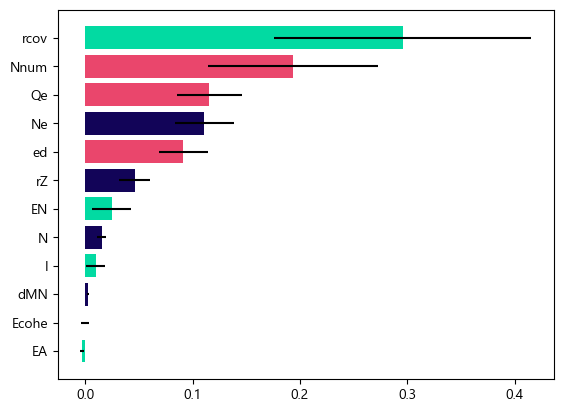

In [34]:
perm_importance_result_train = permutation_importance(best_xgb, x_test, y_test, n_repeats=10)

plot_feature_importances(perm_importance_result_train, x_train.columns)

# 상관계수 분석

In [35]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    plt.show()

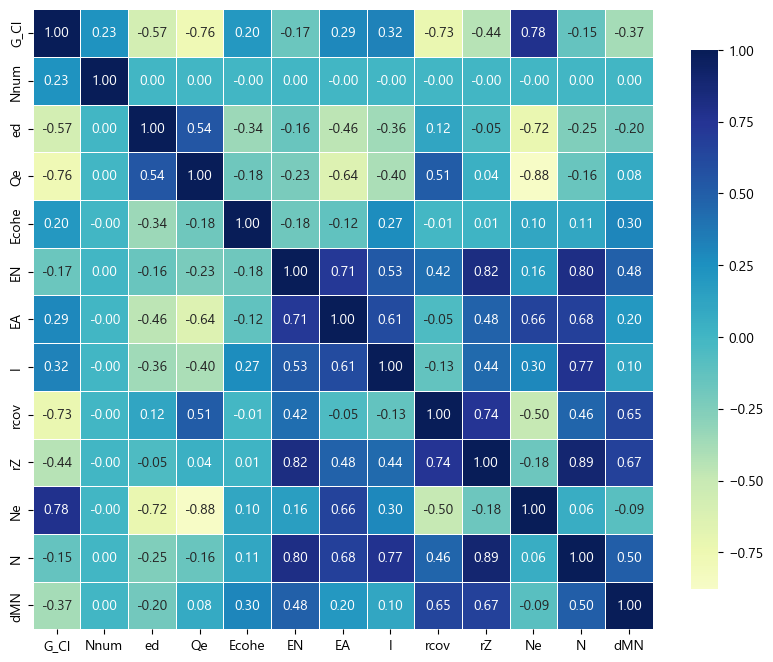

In [36]:
corr = raw_data.iloc[:,1:]
feature_names_corr = np.array(['G_Cl','Nnum', 'ed', 'Qe', 'Ecohe', 'EN', 'EA', 'I', 'rcov', 'rZ', 'Ne', 'N', 'dMN'])

correlation_heatmap(corr[feature_names_corr])

# PCA 분석

#### G_Cl 미포함

In [37]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(x_scaled)

In [38]:
pca.explained_variance_ratio_

array([0.373288  , 0.26957951])

(75,)


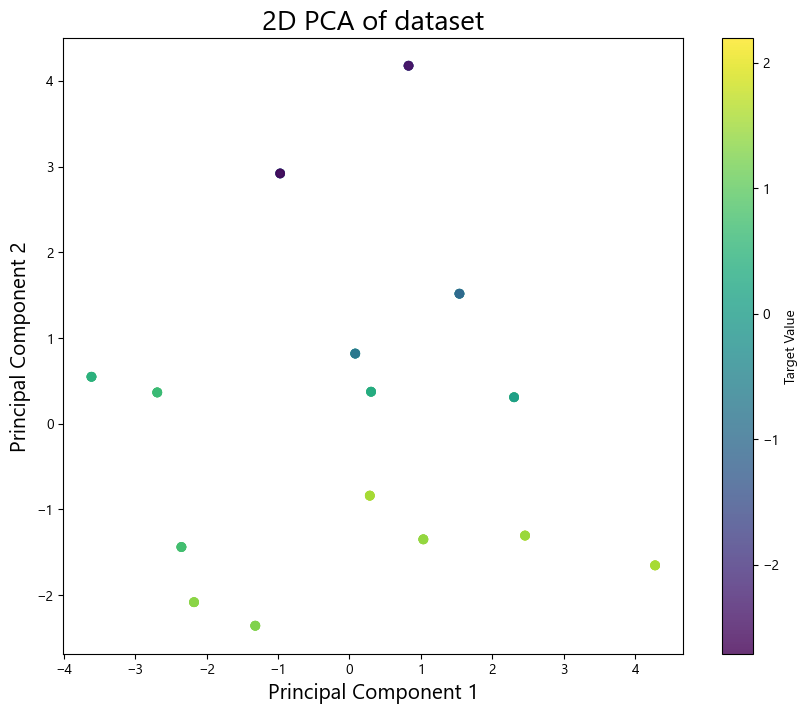

In [39]:
# scatter plot
plt.figure(figsize=(10, 8))
print(X2D[:, 1].shape)
scatter = plt.scatter(X2D[:, 0], X2D[:, 1], c=y, alpha=0.8)
plt.xlabel('Principal Component 1', size = fss)
plt.ylabel('Principal Component 2', size = fss)
plt.title('2D PCA of dataset', size = fs)

#plt.xlim(-10, 10)   # x축 범위 설정
#plt.ylim(-10, 10)   # y축 범위 설정

# Add a color bar
colorbar = plt.colorbar(scatter)
colorbar.set_label('Target Value')

plt.show()

#### G_Cl 포함

In [40]:
pca = PCA(n_components = 2)
X2D = pca.fit_transform(corr)

In [41]:
pca.explained_variance_ratio_

array([0.9785241 , 0.01197474])

(75,)


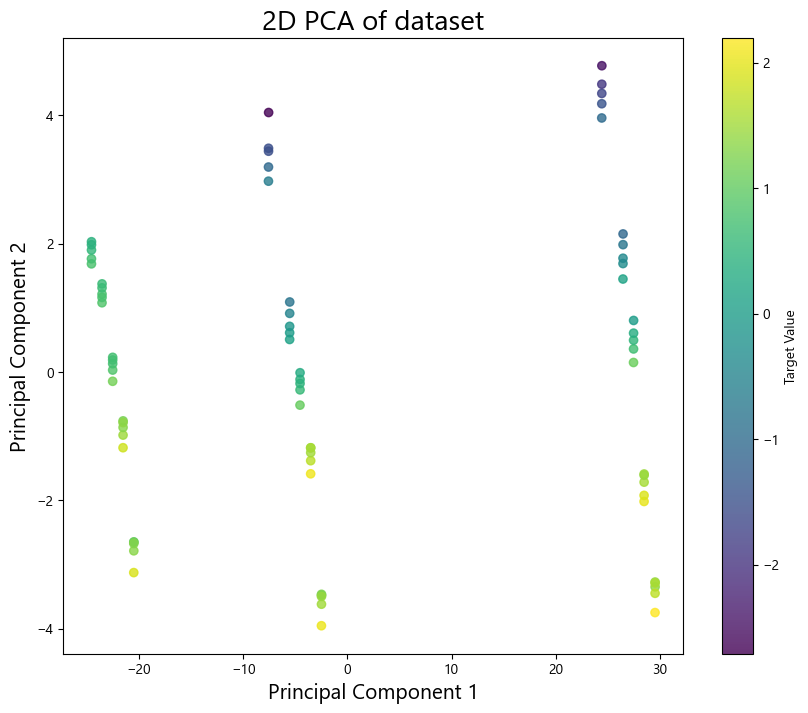

In [42]:
# scatter plot
plt.figure(figsize=(10, 8))
print(X2D[:, 1].shape)
scatter = plt.scatter(X2D[:, 0], X2D[:, 1], c=y, alpha=0.8)
plt.xlabel('Principal Component 1', size = fss)
plt.ylabel('Principal Component 2', size = fss)
plt.title('2D PCA of dataset', size = fs)

#plt.xlim(-10, 10)   # x축 범위 설정
#plt.ylim(-10, 10)   # y축 범위 설정

# Add a color bar
colorbar = plt.colorbar(scatter)
colorbar.set_label('Target Value')

plt.show()